In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Path to dataset
DATA_PATH = r"C:\Users\Aparna Agrawal\Desktop\GNR638\Assign2\Scene-Recognition-with-Bag-of-Words-master\data\Images"
IMG_SIZE = (256,256)
BATCH_SIZE = 32
NUM_CLASSES = 21  # Number of categories

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,   # Normalize pixel values
    validation_split=0.2,  # Split data into training (80%) and validation (20%)
    horizontal_flip=True,
    rotation_range=20
)

# Load images from directory
train_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, validation_data=val_data, epochs=33)

# Save the trained model
model.save("scene_classification_cnn.h5")

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
Epoch 1/33
53/53 [==============================] - 25s 399ms/step - loss: 3.0348 - accuracy: 0.0530 - val_loss: 2.9347 - val_accuracy: 0.0976
Epoch 2/33
53/53 [==============================] - 19s 355ms/step - loss: 2.8735 - accuracy: 0.1196 - val_loss: 2.8306 - val_accuracy: 0.1571
Epoch 3/33
53/53 [==============================] - 19s 358ms/step - loss: 2.7354 - accuracy: 0.1488 - val_loss: 2.7190 - val_accuracy: 0.2119
Epoch 4/33
53/53 [==============================] - 20s 372ms/step - loss: 2.6365 - accuracy: 0.1982 - val_loss: 2.5456 - val_accuracy: 0.2619
Epoch 5/33
53/53 [==============================] - 20s 366ms/step - loss: 2.4903 - accuracy: 0.2381 - val_loss: 2.5212 - val_accuracy: 0.2571
Epoch 6/33
53/53 [==============================] - 19s 355ms/step - loss: 2.4132 - accuracy: 0.2512 - val_loss: 2.4161 - val_accuracy: 0.3071
Epoch 7/33
53/53 [==============================] - 20s 3

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

1/1 [==============================] - 0s 19ms/step


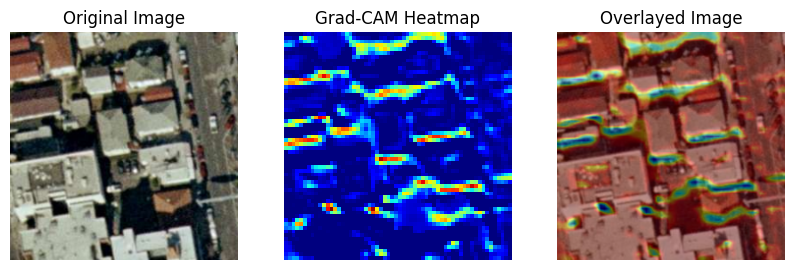

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def compute_gradcam(model, img_array, layer_name, class_idx):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy() 
    pooled_grads = pooled_grads.numpy()    
    
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]  
    
    heatmap = np.mean(conv_outputs, axis=-1) 
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalize heatmap

    return heatmap

# Overlay Grad-CAM heatmap
def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Load test image
test_img_path = r"C:\Users\Aparna Agrawal\Desktop\GNR638\Assign2\Scene-Recognition-with-Bag-of-Words-master\data\Images\buildings\buildings05.tif"
image = cv2.imread(test_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_array = tf.image.resize(image, IMG_SIZE) / 255.0  # Ensure correct shape
img_array = np.expand_dims(img_array, axis=0)

# Get predictions
layer_name = "conv2d_2"  # Check this with model.summary()
class_idx = np.argmax(model.predict(img_array))

# Generate Grad-CAM
heatmap = compute_gradcam(model, img_array, layer_name, class_idx)
cam_image = overlay_gradcam(image, heatmap)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cam_image)
plt.title("Overlayed Image")
plt.axis("off")

plt.show()

1/1 [==============================] - 0s 14ms/step


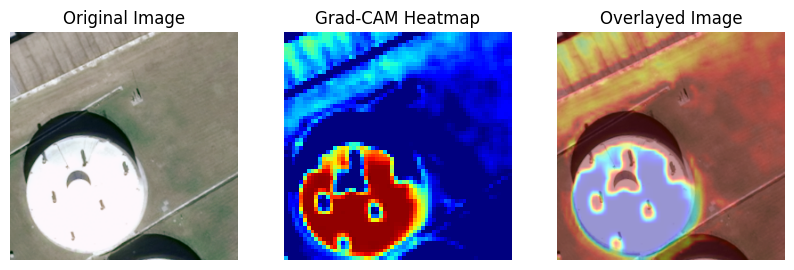

In [4]:
test_img_path =  r"C:\Users\Aparna Agrawal\Desktop\GNR638\Assign2\Scene-Recognition-with-Bag-of-Words-master\data\Images\storagetanks\storagetanks67.tif"
image = cv2.imread(test_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_array = tf.image.resize(image, IMG_SIZE) / 255.0  # Ensure correct shape
img_array = np.expand_dims(img_array, axis=0)

# Get predictions
layer_name = "conv2d_2"  # Check this with model.summary()
class_idx = np.argmax(model.predict(img_array))

# Generate Grad-CAM
heatmap = compute_gradcam(model, img_array, layer_name, class_idx)
cam_image = overlay_gradcam(image, heatmap)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cam_image)
plt.title("Overlayed Image")
plt.axis("off")

plt.show()